In [6]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [7]:
class ElectronicsRepair:
    def __init__(self, arrival_rate, classify_time_func, general_repair_time_func, expert_repair_time_func, warehouse_time_func, sim_duration):
        
        # Parameters
        self.arrival_rate = arrival_rate
        self.classify_time_func = classify_time_func
        self.general_repair_time_func = general_repair_time_func
        self.expert_repair_time_func = expert_repair_time_func
        self.warehouse_time_func = warehouse_time_func
        self.sim_duration = sim_duration
        
        self.rng = np.random.default_rng()
        
        # Simulation states
        self.time = 0
        self.appliances = 0
        self.events_queue = []
        self.events = {
            'arrival': self.process_arrival,
            'end_classify': self.end_classify,
            'end_general_repair': self.end_general_repair,
            'end_expert_repair': self.end_expert_repair,
            'end_warehouse': self.end_warehouse,
        }
        
       # Queues and servers
        self.classify_queue = deque()
        self.classify_status = -1
        self.general_repair_queues = [deque() for _ in range(3)]
        self.general_repair_status = [-1] * 3
        self.expert_repair_queues = [deque() for _ in range(4)]
        self.expert_repair_status = [-1] * 4
        self.warehouse_queues = [deque() for _ in range(2)]
        self.warehouse_status = [-1] * 2
        
        # Data
        self.arrivals = {}
        self.classify_start = {}
        self.classify_end = {}
        self.general_repair_start = {}
        self.general_repair_end = {}
        self.expert_repair_start = {}
        self.expert_repair_end = {}
        self.warehouse_start = {}
        self.warehouse_end = {}
        self.exit_times = {}
        self.paths = {}  # {appliance_id: [nodes visited]}
        self.classify_queue_lengths = []  # (time, length)
        self.general_queue_lengths = []   # (time, total length)
        self.expert_queue_lengths = []    # (time, total length)
        self.warehouse_queue_lengths = [] # (time, total length)
        self.classify_busy_time = 0
        self.general_busy_times = [0] * 3
        self.expert_busy_times = [0] * 4
        self.warehouse_busy_times = [0] * 2
        self.classify_counts = 0
        self.general_counts = [0] * 3
        self.expert_counts = [0] * 4
        self.warehouse_counts = [0] * 2
        self.last_time = 0
    
    def next_arrival(self):
        if self.time >= self.sim_duration:
            return
        time_arrival = self.rng.exponential(1 / self.arrival_rate)
        next_time = self.time + time_arrival
        if next_time < self.sim_duration:
            heapq.heappush(self.events_queue, (next_time, 'arrival'))
    
    def process_arrival(self):
        self.classify_queue_lengths.append((self.time, len(self.classify_queue)))
        self.general_queue_lengths.append((self.time, sum(len(q) for q in self.general_repair_queues)))
        self.expert_queue_lengths.append((self.time, sum(len(q) for q in self.expert_repair_queues)))
        self.warehouse_queue_lengths.append((self.time, sum(len(q) for q in self.warehouse_queues)))
        
        appliance_id = self.appliances
        self.appliances += 1
        self.arrivals[appliance_id] = self.time
        self.paths[appliance_id] = []
        
        if self.classify_status == -1:
            self.process_classify(appliance_id)
        else:
            self.classify_queue.append(appliance_id)
        
        self.next_arrival()
    
    def process_classify(self, appliance_id):
        self.classify_status = appliance_id
        self.classify_start[appliance_id] = self.time
        duration = self.classify_time_func()
        heapq.heappush(self.events_queue, (self.time + duration, 'end_classify', appliance_id))
    
    def process_general_repair(self, server_idx, appliance_id):
        self.general_repair_status[server_idx] = appliance_id
        self.general_repair_start[appliance_id] = self.time
        duration = self.general_repair_time_func()
        heapq.heappush(self.events_queue, (self.time + duration, 'end_general_repair', server_idx))
    
    def process_expert_repair(self, server_idx, appliance_id):
        self.expert_repair_status[server_idx] = appliance_id
        self.expert_repair_start[appliance_id] = self.time
        duration = self.expert_repair_time_func()
        heapq.heappush(self.events_queue, (self.time + duration, 'end_expert_repair', server_idx))
    
    def process_warehouse(self, server_idx, appliance_id):
        self.warehouse_status[server_idx] = appliance_id
        self.warehouse_start[appliance_id] = self.time
        duration = self.warehouse_time_func()
        heapq.heappush(self.events_queue, (self.time + duration, 'end_warehouse', server_idx))
    
    def end_classify(self, appliance_id):
        self.classify_queue_lengths.append((self.time, len(self.classify_queue)))
        self.general_queue_lengths.append((self.time, sum(len(q) for q in self.general_repair_queues)))
        self.expert_queue_lengths.append((self.time, sum(len(q) for q in self.expert_repair_queues)))
        self.warehouse_queue_lengths.append((self.time, sum(len(q) for q in self.warehouse_queues)))
        
        assert self.classify_status == appliance_id
        self.classify_end[appliance_id] = self.time
        self.classify_busy_time += self.time - self.classify_start[appliance_id]
        self.classify_counts += 1
        
        if self.classify_queue:
            next_appliance_id = self.classify_queue.popleft()
            self.process_classify(next_appliance_id)
        else:
            self.classify_status = -1
        
        self.paths[appliance_id].append('classify')
        r = self.rng.random()
        if r < 0.17:  
            self.paths[appliance_id].append('warehouse')
            queue_idx = self.rng.integers(0, 2)
            if self.warehouse_status[queue_idx] == -1:
                self.process_warehouse(queue_idx, appliance_id)
            else:
                self.warehouse_queues[queue_idx].append(appliance_id)
        else:
            r2 = self.rng.random()
            if r2 < 0.57:  
                self.paths[appliance_id].append('general')
                queue_idx = self.rng.integers(0, 3)
                if self.general_repair_status[queue_idx] == -1:
                    self.process_general_repair(queue_idx, appliance_id)
                else:
                    self.general_repair_queues[queue_idx].append(appliance_id)
            else:  
                self.paths[appliance_id].append('expert')
                queue_idx = self.rng.integers(0, 4)
                if self.expert_repair_status[queue_idx] == -1:
                    self.process_expert_repair(queue_idx, appliance_id)
                else:
                    self.expert_repair_queues[queue_idx].append(appliance_id)
    
    def end_general_repair(self, server_idx):
        self.classify_queue_lengths.append((self.time, len(self.classify_queue)))
        self.general_queue_lengths.append((self.time, sum(len(q) for q in self.general_repair_queues)))
        self.expert_queue_lengths.append((self.time, sum(len(q) for q in self.expert_repair_queues)))
        self.warehouse_queue_lengths.append((self.time, sum(len(q) for q in self.warehouse_queues)))
        
        assert self.general_repair_status[server_idx] != -1
        appliance_id = self.general_repair_status[server_idx]
        self.general_repair_end[appliance_id] = self.time
        self.general_busy_times[server_idx] += self.time - self.general_repair_start[appliance_id]
        self.general_counts[server_idx] += 1
        
        if self.general_repair_queues[server_idx]:
            next_appliance_id = self.general_repair_queues[server_idx].popleft()
            self.process_general_repair(server_idx, next_appliance_id)
        else:
            self.general_repair_status[server_idx] = -1
        
        if self.rng.random() < 0.05: 
            self.paths[appliance_id].append('classify')
            if self.classify_status == -1:
                self.process_classify(appliance_id)
            else:
                self.classify_queue.append(appliance_id)
        else:
            self.paths[appliance_id].append('warehouse')
            queue_idx = self.rng.integers(0, 2)
            if self.warehouse_status[queue_idx] == -1:
                self.process_warehouse(queue_idx, appliance_id)
            else:
                self.warehouse_queues[queue_idx].append(appliance_id)
    
    def end_expert_repair(self, server_idx):
        self.classify_queue_lengths.append((self.time, len(self.classify_queue)))
        self.general_queue_lengths.append((self.time, sum(len(q) for q in self.general_repair_queues)))
        self.expert_queue_lengths.append((self.time, sum(len(q) for q in self.expert_repair_queues)))
        self.warehouse_queue_lengths.append((self.time, sum(len(q) for q in self.warehouse_queues)))
        
        assert self.expert_repair_status[server_idx] != -1
        appliance_id = self.expert_repair_status[server_idx]
        self.expert_repair_end[appliance_id] = self.time
        self.expert_busy_times[server_idx] += self.time - self.expert_repair_start[appliance_id]
        self.expert_counts[server_idx] += 1
        
        if self.expert_repair_queues[server_idx]:
            next_appliance_id = self.expert_repair_queues[server_idx].popleft()
            self.process_expert_repair(server_idx, next_appliance_id)
        else:
            self.expert_repair_status[server_idx] = -1
        
        self.paths[appliance_id].append('warehouse')
        queue_idx = self.rng.integers(0, 2)
        if self.warehouse_status[queue_idx] == -1:
            self.process_warehouse(queue_idx, appliance_id)
        else:
            self.warehouse_queues[queue_idx].append(appliance_id)
    
    def end_warehouse(self, server_idx):
        self.classify_queue_lengths.append((self.time, len(self.classify_queue)))
        self.general_queue_lengths.append((self.time, sum(len(q) for q in self.general_repair_queues)))
        self.expert_queue_lengths.append((self.time, sum(len(q) for q in self.expert_repair_queues)))
        self.warehouse_queue_lengths.append((self.time, sum(len(q) for q in self.warehouse_queues)))
        
        assert self.warehouse_status[server_idx] != -1
        appliance_id = self.warehouse_status[server_idx]
        self.warehouse_end[appliance_id] = self.time
        self.warehouse_busy_times[server_idx] += self.time - self.warehouse_start[appliance_id]
        self.warehouse_counts[server_idx] += 1
        
        if self.warehouse_queues[server_idx]:
            next_appliance_id = self.warehouse_queues[server_idx].popleft()
            self.process_warehouse(server_idx, next_appliance_id)
        else:
            self.warehouse_status[server_idx] = -1
        
        self.exit_times[appliance_id] = self.time
    
    def run(self):
        self.next_arrival()
        while self.events_queue:
            event = heapq.heappop(self.events_queue)
            self.time = event[0]
            event_type = event[1]
            args = event[2:] if len(event) > 2 else ()
            self.events[event_type](*args)
    
    def statistics(self):
        system_times = []
        classify_times = []
        general_times = []
        expert_times = []
        warehouse_times = []
        classify_wait_times = []
        general_wait_times = []
        expert_wait_times = []
        warehouse_wait_times = []
        path_counts = {
            'classify_warehouse': 0,
            'classify_general_warehouse': 0,
            'classify_expert_warehouse': 0,
            'classify_general_classify_warehouse': 0,  
            'classify_general_classify_expert_warehouse': 0
        }
        
        for appliance_id in self.arrivals:
            if appliance_id in self.exit_times:
                system_times.append(self.exit_times[appliance_id] - self.arrivals[appliance_id])
            if appliance_id in self.classify_end and appliance_id in self.classify_start:
                classify_times.append(self.classify_end[appliance_id] - self.classify_start[appliance_id])
            if appliance_id in self.general_repair_end and appliance_id in self.general_repair_start:
                general_times.append(self.general_repair_end[appliance_id] - self.general_repair_start[appliance_id])
            if appliance_id in self.expert_repair_end and appliance_id in self.expert_repair_start:
                expert_times.append(self.expert_repair_end[appliance_id] - self.expert_repair_start[appliance_id])
            if appliance_id in self.warehouse_end and appliance_id in self.warehouse_start:
                warehouse_times.append(self.warehouse_end[appliance_id] - self.warehouse_start[appliance_id])
            if appliance_id in self.classify_start:
                classify_wait_times.append(self.classify_start[appliance_id] - self.arrivals[appliance_id])
            if appliance_id in self.general_repair_start and appliance_id in self.classify_end:
                general_wait_times.append(self.general_repair_start[appliance_id] - self.classify_end[appliance_id])
            if appliance_id in self.expert_repair_start and appliance_id in self.classify_end:
                expert_wait_times.append(self.expert_repair_start[appliance_id] - self.classify_end[appliance_id])
            if appliance_id in self.warehouse_start:
                if appliance_id in self.classify_end and 'classify' in self.paths[appliance_id][-2:]:
                    warehouse_wait_times.append(self.warehouse_start[appliance_id] - self.classify_end[appliance_id])
                elif appliance_id in self.general_repair_end:
                    warehouse_wait_times.append(self.warehouse_start[appliance_id] - self.general_repair_end[appliance_id])
                elif appliance_id in self.expert_repair_end:
                    warehouse_wait_times.append(self.warehouse_start[appliance_id] - self.expert_repair_end[appliance_id])
            
            path = self.paths.get(appliance_id, [])
            path_str = '_'.join(path)
            if path_str in path_counts:
                path_counts[path_str] += 1
            elif path_str == 'classify_general_classify_expert_warehouse':
                path_counts['classify_general_classify_expert_warehouse'] += 1
            elif 'classify_general_classify' in path_str:
                path_counts['classify_general_classify_warehouse'] += 1
        
        system_times = [t * 60 for t in system_times]  
        classify_times = [t * 60 for t in classify_times]  
        classify_wait_times = [t * 60 for t in classify_wait_times]
        general_times = [t * 60 for t in general_times]
        expert_times = [t * 60 for t in expert_times]
        warehouse_times = [t * 60 for t in warehouse_times]
        general_wait_times = [t * 60 for t in general_wait_times]
        expert_wait_times = [t * 60 for t in expert_wait_times]
        warehouse_wait_times = [t * 60 for t in warehouse_wait_times]
        
        total_time = self.time
        avg_classify_queue = 0
        avg_general_queue = 0
        avg_expert_queue = 0
        avg_warehouse_queue = 0
        if total_time > 0:
            for i in range(len(self.classify_queue_lengths) - 1):
                time_delta = self.classify_queue_lengths[i + 1][0] - self.classify_queue_lengths[i][0]
                avg_classify_queue += self.classify_queue_lengths[i][1] * time_delta
                avg_general_queue += self.general_queue_lengths[i][1] * time_delta
                avg_expert_queue += self.expert_queue_lengths[i][1] * time_delta
                avg_warehouse_queue += self.warehouse_queue_lengths[i][1] * time_delta
            avg_classify_queue /= total_time
            avg_general_queue /= total_time
            avg_expert_queue /= total_time
            avg_warehouse_queue /= total_time
        
        utilization_classify = (self.classify_busy_time / total_time) * 100 if total_time > 0 else 0
        utilization_general = [(t / total_time) * 100 for t in self.general_busy_times] if total_time > 0 else [0] * 3
        utilization_expert = [(t / total_time) * 100 for t in self.expert_busy_times] if total_time > 0 else [0] * 4
        utilization_warehouse = [(t / total_time) * 100 for t in self.warehouse_busy_times] if total_time > 0 else [0] * 2
        
        return {
            'avg_classify_queue': avg_classify_queue,
            'avg_general_queue': avg_general_queue,
            'avg_expert_queue': avg_expert_queue,
            'avg_warehouse_queue': avg_warehouse_queue,
            'classify_queue_lengths': [l for _, l in self.classify_queue_lengths],
            'general_queue_lengths': [l for _, l in self.general_queue_lengths],
            'expert_queue_lengths': [l for _, l in self.expert_queue_lengths],
            'warehouse_queue_lengths': [l for _, l in self.warehouse_queue_lengths],
            'system_times': system_times,
            'classify_times': classify_times,
            'general_times': general_times,
            'expert_times': expert_times,
            'warehouse_times': warehouse_times,
            'classify_wait_times': classify_wait_times,
            'general_wait_times': general_wait_times,
            'expert_wait_times': expert_wait_times,
            'warehouse_wait_times': warehouse_wait_times,
            'path_counts': path_counts,
            'utilization_classify': utilization_classify,
            'utilization_general': utilization_general,
            'utilization_expert': utilization_expert,
            'utilization_warehouse': utilization_warehouse,
            'classify_counts': self.classify_counts,
            'general_counts': self.general_counts,
            'expert_counts': self.expert_counts,
            'warehouse_counts': self.warehouse_counts,
        }



In [8]:
sim = ElectronicsRepair(
    arrival_rate=9,
    classify_time_func=lambda: np.random.exponential(6/60),
    general_repair_time_func=lambda: np.random.exponential(35/60),
    expert_repair_time_func=lambda: np.random.exponential(65/60),
    warehouse_time_func=lambda: np.random.exponential(12.5/60),
    sim_duration=24
)
sim.run()
stats = sim.statistics()

## Número promedio de aparatos en la cola de cada sección
Número promedio de aparatos en cada nodo. El gráfico de barras compara las colas entre secciones.

Número promedio de aparatos en clasificación: 6.26
Número promedio de aparatos en reparaciones generales: 4.27
Número promedio de aparatos en expertos: 8.55
Número promedio de aparatos en almacén: 3.70


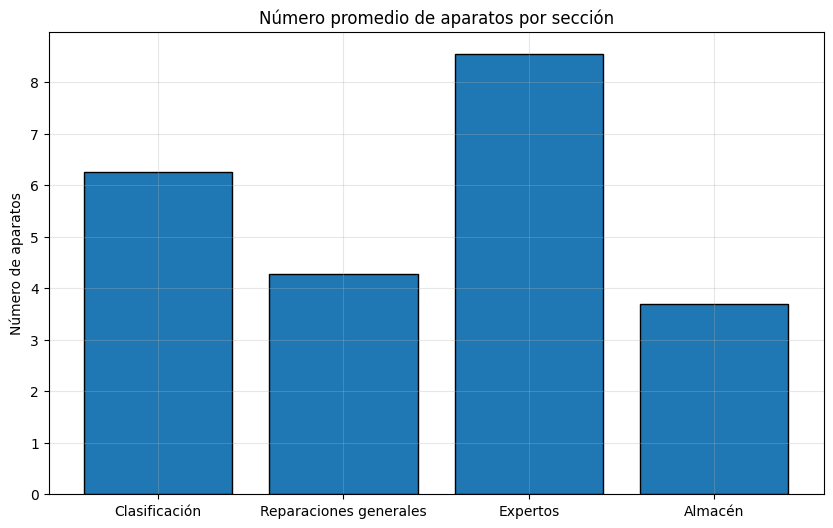

In [9]:
print(f"Número promedio de aparatos en clasificación: {stats['avg_classify_queue']:.2f}")
print(f"Número promedio de aparatos en reparaciones generales: {stats['avg_general_queue']:.2f}")
print(f"Número promedio de aparatos en expertos: {stats['avg_expert_queue']:.2f}")
print(f"Número promedio de aparatos en almacén: {stats['avg_warehouse_queue']:.2f}")

plt.figure(figsize=(10, 6))
plt.bar(['Clasificación', 'Reparaciones generales', 'Expertos', 'Almacén'],
        [stats['avg_classify_queue'], stats['avg_general_queue'], stats['avg_expert_queue'], stats['avg_warehouse_queue']],
        edgecolor='black')
plt.title('Número promedio de aparatos por sección')
plt.ylabel('Número de aparatos')
plt.grid(True, alpha=0.3)
plt.show()

## Tiempo de espera en cola por sección
El diagrama de caja muestra la distribución de los tiempos de espera por sección.

Tiempo promedio de espera en cola para clasificación: 64.03 minutos
Tiempo promedio de espera en cola para reparaciones generales: 74.90 minutos
Tiempo promedio de espera en cola para expertos: 224.15 minutos
Tiempo promedio de espera en cola para almacén: 37.71 minutos


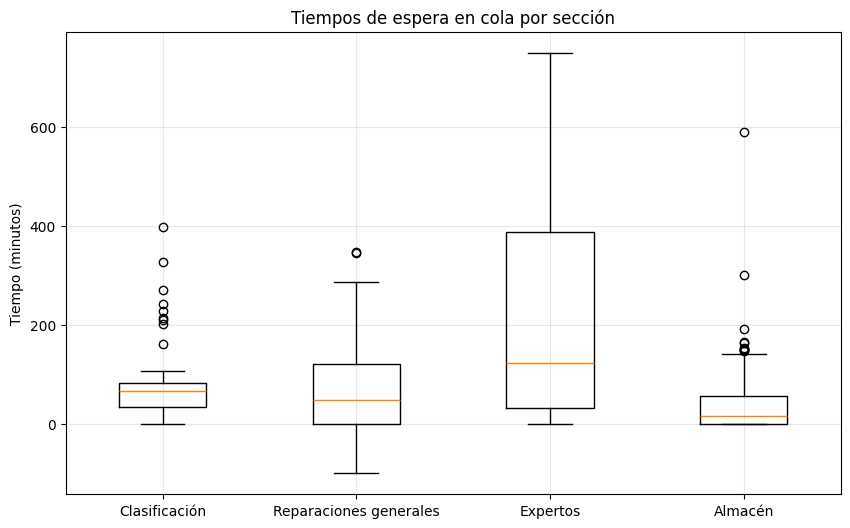

In [10]:
avg_classify_wait = np.mean(stats['classify_wait_times']) if stats['classify_wait_times'] else 0
avg_general_wait = np.mean(stats['general_wait_times']) if stats['general_wait_times'] else 0
avg_expert_wait = np.mean(stats['expert_wait_times']) if stats['expert_wait_times'] else 0
avg_warehouse_wait = np.mean(stats['warehouse_wait_times']) if stats['warehouse_wait_times'] else 0

print(f"Tiempo promedio de espera en cola para clasificación: {avg_classify_wait:.2f} minutos")
print(f"Tiempo promedio de espera en cola para reparaciones generales: {avg_general_wait:.2f} minutos")
print(f"Tiempo promedio de espera en cola para expertos: {avg_expert_wait:.2f} minutos")
print(f"Tiempo promedio de espera en cola para almacén: {avg_warehouse_wait:.2f} minutos")

plt.figure(figsize=(10, 6))
plt.boxplot([stats['classify_wait_times'], stats['general_wait_times'], stats['expert_wait_times'], stats['warehouse_wait_times']],
            labels=['Clasificación', 'Reparaciones generales', 'Expertos', 'Almacén'])
plt.title('Tiempos de espera en cola por sección')
plt.ylabel('Tiempo (minutos)')
plt.grid(True, alpha=0.3)
plt.show()

## Tiempo promedio que un aparato pasa en cada sección
Se calcula el tiempo promedio (espera + servicio) en cada sección. El diagrama de caja muestra la distribución de los tiempos por sección.

Tiempo promedio en clasificación: 6.31 minutos
Tiempo promedio en reparaciones generales: 34.16 minutos
Tiempo promedio en expertos: 64.88 minutos
Tiempo promedio en almacén: 11.33 minutos


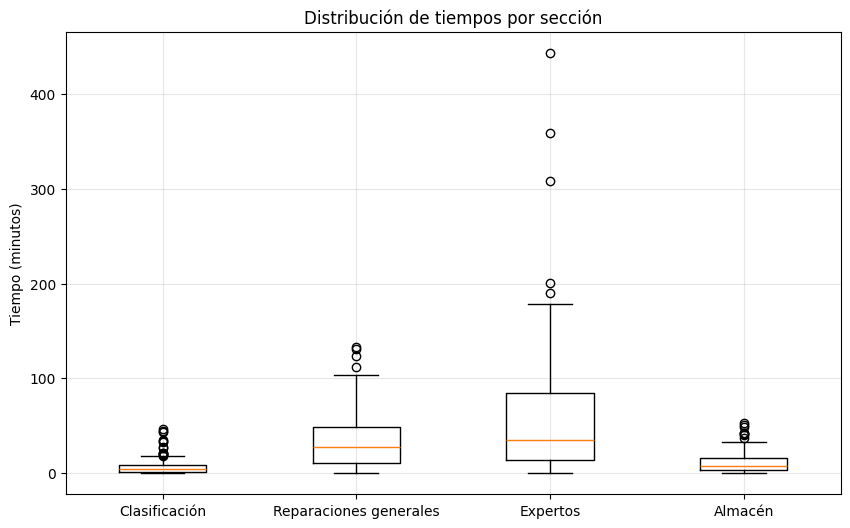

In [11]:
avg_classify_time = np.mean(stats['classify_times']) if stats['classify_times'] else 0
avg_general_time = np.mean(stats['general_times']) if stats['general_times'] else 0
avg_expert_time = np.mean(stats['expert_times']) if stats['expert_times'] else 0
avg_warehouse_time = np.mean(stats['warehouse_times']) if stats['warehouse_times'] else 0

print(f"Tiempo promedio en clasificación: {avg_classify_time:.2f} minutos")
print(f"Tiempo promedio en reparaciones generales: {avg_general_time:.2f} minutos")
print(f"Tiempo promedio en expertos: {avg_expert_time:.2f} minutos")
print(f"Tiempo promedio en almacén: {avg_warehouse_time:.2f} minutos")

plt.figure(figsize=(10, 6))
plt.boxplot([stats['classify_times'], stats['general_times'], stats['expert_times'], stats['warehouse_times']],
            labels=['Clasificación', 'Reparaciones generales', 'Expertos', 'Almacén'])
plt.title('Distribución de tiempos por sección')
plt.ylabel('Tiempo (minutos)')
plt.grid(True, alpha=0.3)
plt.show()

## Número de aparatos por tipo de trayectoria
Se muestra la cantidad de aparatos según las posibles trayectorias:
-  Clasificación -> Almacén
-  Clasificación -> General -> Almacén
-  Clasisificacion -> Experto -> Almacén
-  Clasificación -> General -> Clasificación -> Almacén

Número de aparatos por trayectoria:
Clasificación a Almacén: 40
Clasificación a General: 93
Clasisificacion a Experto : 76
Clasificación a General a Clasificación a Almacén: 9
Clasificación a General a Clasificación a Experto: 0


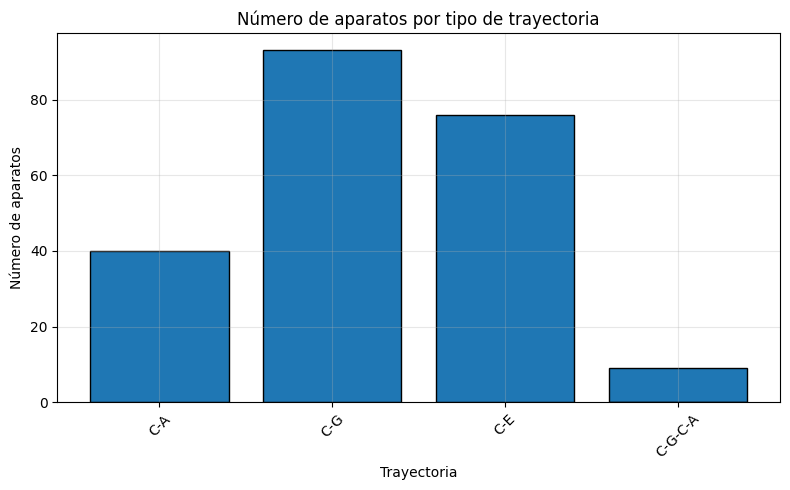

In [ ]:
traduction = {
    "classify_warehouse" : "Clasificación a Almacén",
    "classify_general_warehouse": "Clasificación a General",
    "classify_expert_warehouse" : "Clasisificacion a Experto ",
    "classify_general_classify_warehouse" : "Clasificación a General a Clasificación a Almacén",
    "classify_general_classify_expert_warehouse" : "Clasificación a General a Clasificación a Experto",
}

legend = {
    "classify_warehouse" : "C-A",
    "classify_general_warehouse": "C-G",
    "classify_expert_warehouse" : "C-E",
    "classify_general_classify_warehouse" : "C-G-C-A",
    "classify_general_classify_expert_warehouse" : "C-G-C-A",
}

path_counts = stats['path_counts']
print("Número de aparatos por trayectoria:")
for path, count in path_counts.items():
    print(f"{traduction[path]}: {count}")
    
plt.figure(figsize=(8, 5))
plt.bar([legend[path] for path in path_counts.keys()], path_counts.values(), edgecolor='black')
plt.title('Número de aparatos por tipo de trayectoria')
plt.xlabel('Trayectoria')
plt.ylabel('Número de aparatos')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Distribución de aparatos atendidos por servidor
Se muestra en el gráfico de barras la cantidad de aparatos atendidos por cada servidor: 
- Clasificación 
- Reparación general
- Expertos
- Almacén

Aparatos atendidos en clasificación: 227
Aparatos atendidos por servidor de reparaciones generales: [30, 41, 36]
Aparatos atendidos por servidor de expertos: [22, 18, 20, 18]
Aparatos atendidos por servidor de almacén: [98, 120]


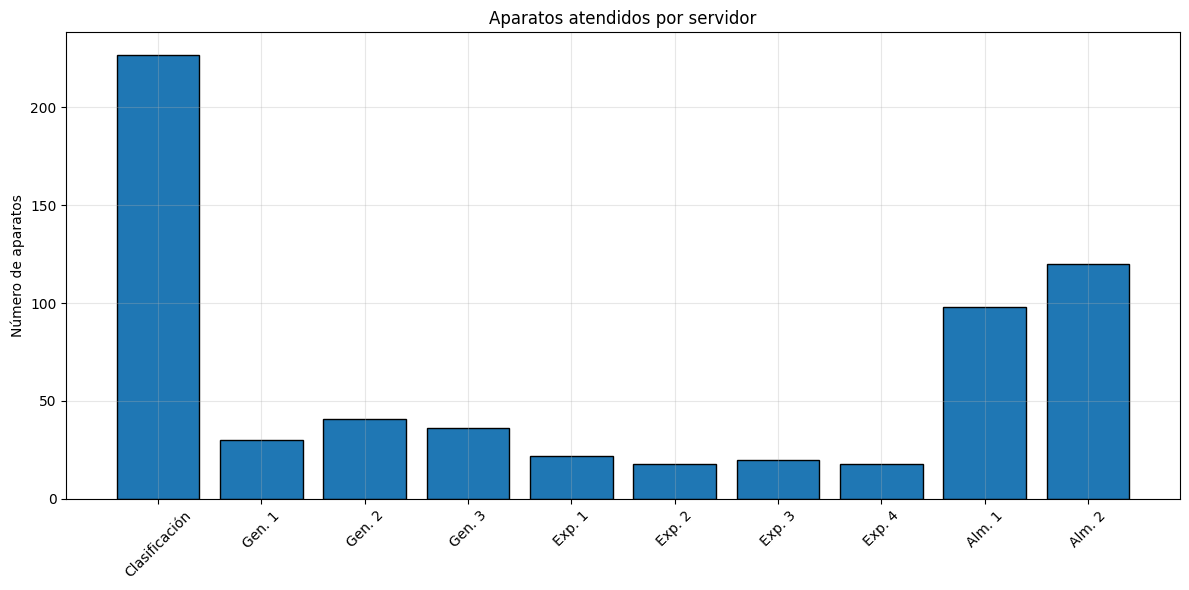

In [13]:
print(f"Aparatos atendidos en clasificación: {stats['classify_counts']}")
print(f"Aparatos atendidos por servidor de reparaciones generales: {stats['general_counts']}")
print(f"Aparatos atendidos por servidor de expertos: {stats['expert_counts']}")
print(f"Aparatos atendidos por servidor de almacén: {stats['warehouse_counts']}")

plt.figure(figsize=(12, 6))
plt.bar(['Clasificación'] + [f'Gen. {i+1}' for i in range(3)] + [f'Exp. {i+1}' for i in range(4)] + [f'Alm. {i+1}' for i in range(2)],
        [stats['classify_counts']] + stats['general_counts'] + stats['expert_counts'] + stats['warehouse_counts'],
        edgecolor='black')
plt.title('Aparatos atendidos por servidor')
plt.ylabel('Número de aparatos')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Tasa de reingreso a clasificación
Se calcula la proporción de aparatos que vuelven a clasificación desde reparaciones generales. El gráfico de barras compara reingresos con otras trayectorias.

Tasa de reingreso a clasificación desde reparaciones generales: 4.13%
Número de aparatos que reingresaron: 9


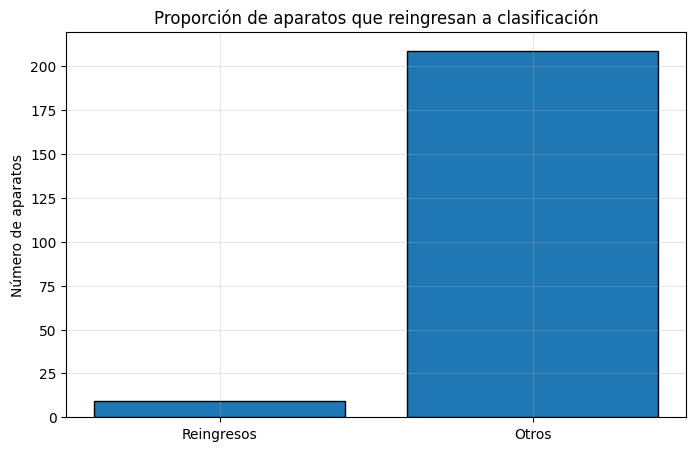

In [14]:
reingress_count = stats['path_counts'].get('classify_general_classify_warehouse', 0)
total_general = sum(stats['path_counts'].values())
reingress_rate = (reingress_count / total_general * 100) if total_general > 0 else 0

print(f"Tasa de reingreso a clasificación desde reparaciones generales: {reingress_rate:.2f}%")
print(f"Número de aparatos que reingresaron: {reingress_count}")

plt.figure(figsize=(8, 5))
plt.bar(['Reingresos', 'Otros'], [reingress_count, total_general - reingress_count], edgecolor='black')
plt.title('Proporción de aparatos que reingresan a clasificación')
plt.ylabel('Número de aparatos')
plt.grid(True, alpha=0.3)
plt.show()

## Utilización de los servidores
Se muestra el porcentaje de tiempo que pasa un servidor ocupado.

Utilización de clasificación: 69.00%
Utilización de reparaciones generales: ['43.04%', '55.98%', '78.77%']
Utilización de expertos: ['61.53%', '36.21%', '92.21%', '57.21%']
Utilización de almacén: ['53.10%', '67.57%']


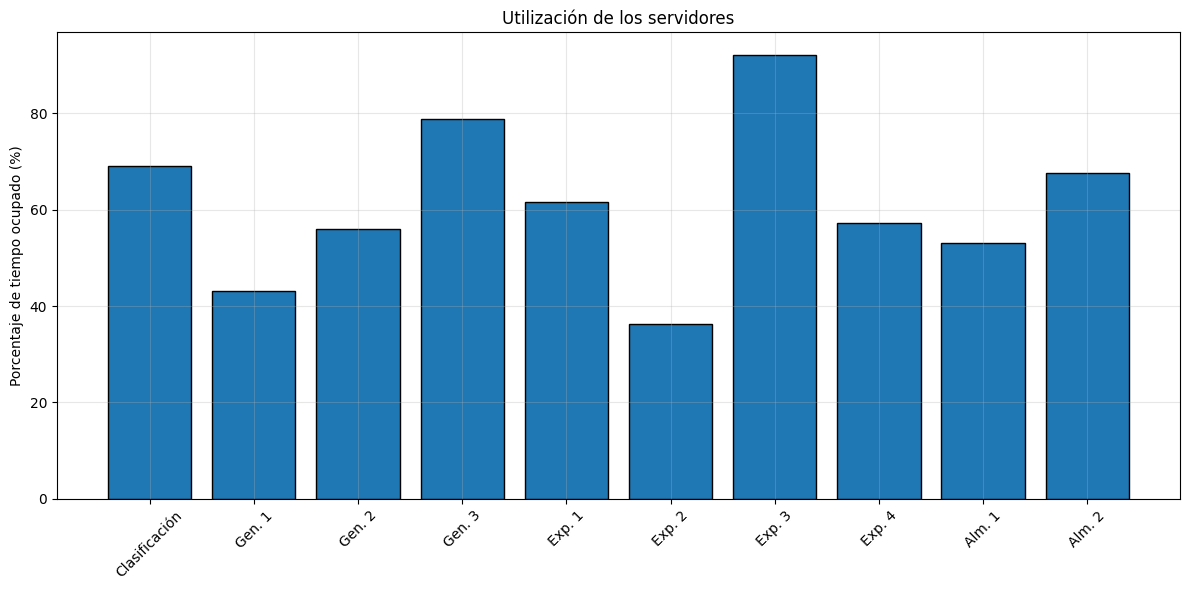

In [15]:
print(f"Utilización de clasificación: {stats['utilization_classify']:.2f}%")
print(f"Utilización de reparaciones generales: {[f'{u:.2f}%' for u in stats['utilization_general']]}")
print(f"Utilización de expertos: {[f'{u:.2f}%' for u in stats['utilization_expert']]}")
print(f"Utilización de almacén: {[f'{u:.2f}%' for u in stats['utilization_warehouse']]}")

plt.figure(figsize=(12, 6))
plt.bar(['Clasificación'] + [f'Gen. {i+1}' for i in range(3)] + [f'Exp. {i+1}' for i in range(4)] + [f'Alm. {i+1}' for i in range(2)],
        [stats['utilization_classify']] + stats['utilization_general'] + stats['utilization_expert'] + stats['utilization_warehouse'],
        edgecolor='black')
plt.title('Utilización de los servidores')
plt.ylabel('Porcentaje de tiempo ocupado (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Tiempo medio que un aparato está en la empresa
El gráfico de tallo muestra los tiempos de cada aparato completado.

Tiempo medio en la empresa: 271.78 minutos


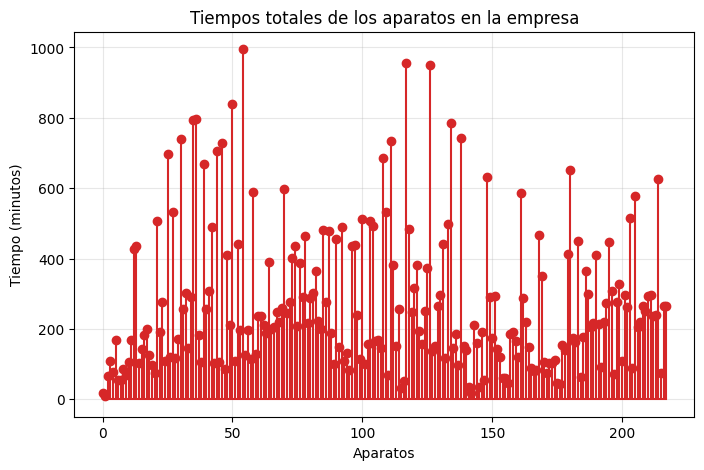

In [16]:
avg_system_time = np.mean(stats['system_times']) if stats['system_times'] else 0

print(f"Tiempo medio en la empresa: {avg_system_time:.2f} minutos")

plt.figure(figsize=(8, 5))
plt.stem(range(len(stats['system_times'])), stats['system_times'], 'C3-')
plt.title('Tiempos totales de los aparatos en la empresa')
plt.xlabel('Aparatos')
plt.ylabel('Tiempo (minutos)')
plt.grid(True, alpha=0.3)
plt.show()